In [1]:
import tensorflow as tf  # version 1.5

/home/schowell/data/myPrograms/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:493: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/schowell/data/myPrograms/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:494: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/schowell/data/myPrograms/miniconda3/envs/tf/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:495: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
import numpy as np
import pandas as pd

In [3]:
import seaborn as sns

In [4]:
from bokeh import plotting
from bokeh.resources import INLINE

In [5]:
import bball

In [6]:
plotting.output_notebook(resources=INLINE)

Loading BokehJS ...

In [7]:
# fname_dataset = '50000_shot_angles.csv'
fname_dataset = '50000000_shot_angles.csv'

In [8]:
dataset = pd.read_csv(fname_dataset, names=['Angle', 'Distance', 'Height', 'Speed'])

In [9]:
dataset.head()

,Angle,Distance,Height,Speed
0,83.031930,18.225621,5.288143,50.484106
1,75.474748,18.309033,3.376883,36.243455
2,86.108276,14.774002,7.096024,60.159853
3,82.167737,23.035271,6.592004,53.233724
4,85.535979,7.273430,0.985080,41.226911


In [10]:
dataset.isna().sum()

Angle       0
Distance    0
Height      0
Speed       0
dtype: int64

Shouldn't be any nan values but remove any just in case.

In [11]:
train_dataset = dataset.sample(frac=0.8, random_state=123)
test_dataset = dataset.drop(train_dataset.index)

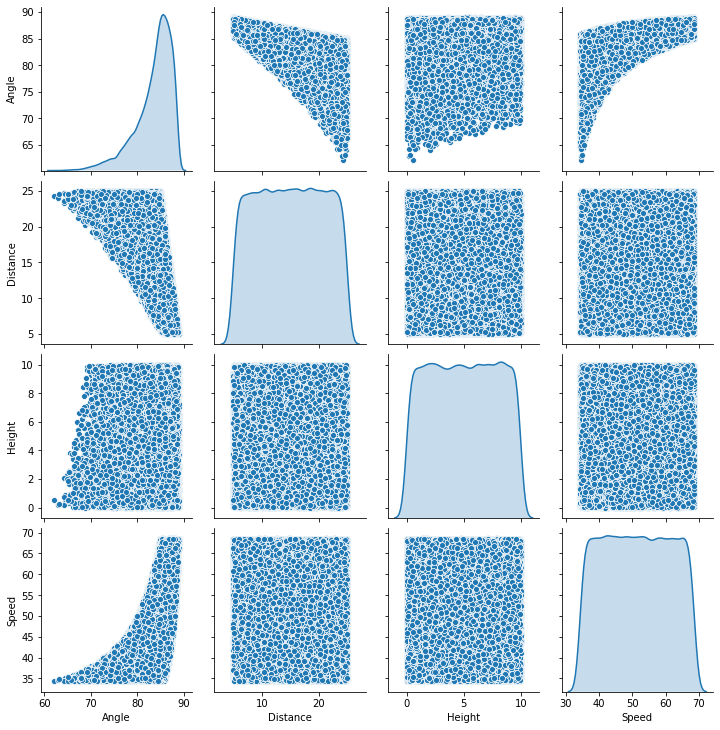

In [52]:
sns.pairplot(train_dataset, diag_kind='kde')

In [12]:
train_labels = train_dataset.pop('Angle')
test_labels = test_dataset.pop('Angle')

In [13]:
TRAIN_MEAN = train_dataset.mean()
TRAIN_STD = train_dataset.std()

In [14]:
def norm(x): 
    normalized = (x - TRAIN_MEAN) / TRAIN_STD
    return normalized

In [15]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [44]:
n_inputs = 3
n_hidden1 = 3
n_hidden2 = 3
n_outputs = 1

In [69]:
batch_size = 50
n_iterations = len(train_dataset) // batch_size
save_iterations = 10000


# ~~~Build the neural network~~~
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
y = tf.placeholder(tf.float32, shape=[None, n_outputs])

initializer = tf.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu,
                          kernel_initializer=initializer)
# angle = tf.layers.dense(hidden1, n_outputs, kernel_initializer=initializer)
hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.elu,
                          kernel_initializer=initializer)
angle = tf.layers.dense(hidden2, n_outputs, kernel_initializer=initializer)
# by not providing an activation function to this second layer, it defaults
# to a 'linear' activation, or no activation. This is appropriate for
# continuous output, across all possible real numbers.

learning_rate = 0.01
loss = tf.reduce_mean(tf.square(angle - y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

# this needs to come AFTER setting up the neural network and optimizer
init = tf.global_variables_initializer()


In [70]:
saver = tf.train.Saver()
path_model = 'regression_02/model.ckpt'
with tf.Session() as sess:
    init.run()
    for i in range(n_iterations):
        X_batch = normed_train_data[i*batch_size:(i+1)*batch_size].values.reshape((-1, n_inputs))
        y_batch = train_labels[i*batch_size:(i+1)*batch_size].values.reshape((-1, n_outputs))
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if i % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(i, '\tMSE:', mse)
            if mse < 0.1:
                break
    saver.save(sess, path_model)

0 	MSE: 7147.9814
100 	MSE: 3404.6448
200 	MSE: 237.10483
300 	MSE: 5.9138136
400 	MSE: 2.404727
500 	MSE: 1.0912807
600 	MSE: 0.76703864
700 	MSE: 0.64063257
800 	MSE: 0.49160334
900 	MSE: 0.850656
1000 	MSE: 0.3781669
1100 	MSE: 0.33329037
1200 	MSE: 0.45468247
1300 	MSE: 0.28178063
1400 	MSE: 0.34367028
1500 	MSE: 0.9070418
1600 	MSE: 0.22076775
1700 	MSE: 0.36648142
1800 	MSE: 0.8085264
1900 	MSE: 1.3357686
2000 	MSE: 0.19218042
2100 	MSE: 0.2875335
2200 	MSE: 0.43353176
2300 	MSE: 0.5540558
2400 	MSE: 1.4624469
2500 	MSE: 0.46465167
2600 	MSE: 1.106158
2700 	MSE: 0.3458737
2800 	MSE: 0.26091778
2900 	MSE: 0.8249891
3000 	MSE: 0.35982782
3100 	MSE: 0.6418294
3200 	MSE: 0.589846
3300 	MSE: 0.4618726
3400 	MSE: 0.3416038
3500 	MSE: 1.3428535
3600 	MSE: 0.8531672
3700 	MSE: 0.4764513
3800 	MSE: 0.8156227
3900 	MSE: 0.79416734
4000 	MSE: 0.39175963
4100 	MSE: 0.3585849
4200 	MSE: 1.148047
4300 	MSE: 0.329569
4400 	MSE: 1.2341504
4500 	MSE: 0.8871439
4600 	MSE: 0.4463982
4700 	MSE: 0.64

In [71]:
def predict(normed_params, path_model):
    with tf.Session() as sess:
        init.run()
        saver.restore(sess, path_model)
        pred_angle = sess.run(angle, feed_dict={X: normed_params.values.reshape((-1, n_inputs))})
    return pred_angle

In [72]:
n_test = 13000 * 50 // 5

In [73]:
pred_angles = predict(normed_test_data[:n_test], path_model)

INFO:tensorflow:Restoring parameters from regression_02/model.ckpt


In [74]:
test_dataset.head()

,Distance,Height,Speed
0,18.225621,5.288143,50.484106
7,17.926240,1.999928,64.690782
26,20.583528,0.078918,35.598659
28,24.542198,1.967983,45.812659
29,10.968586,0.373252,56.904261


In [75]:
pred_angles[:5]

array([[83.29558],
       [85.89897],
       [71.52522],
       [77.36752],
       [86.95422]], dtype=float32)

In [76]:
test_labels[:5]

0     83.031930
7     85.832770
26    70.533399
28    78.136462
29    86.643474
Name: Angle, dtype: float64

In [77]:
test_results = pd.DataFrame(test_labels[:n_test].astype(np.float))
test_results['Predicted'] = pred_angles.reshape(test_labels[:n_test].shape)
test_results['Difference'] = test_results.Angle - test_results.Predicted

In [78]:
test_results.head()

,Angle,Predicted,Difference
0,83.031930,83.295578,-0.263648
7,85.832770,85.898972,-0.066202
26,70.533399,71.525223,-0.991824
28,78.136462,77.367523,0.768939
29,86.643474,86.954224,-0.310749


In [79]:
test_results.describe(include='all')

,Angle,Predicted,Difference
count,130000.000000,130000.000000,130000.000000
mean,83.667526,83.685951,-0.018425
std,3.913157,3.907401,0.343986
min,59.840301,65.744270,-5.903969
25%,81.861288,81.944927,-0.255680
50%,84.682600,84.593338,-0.103146
75%,86.489888,86.546421,0.149799
max,89.014806,88.857780,1.809055


In [80]:
len(test_dataset.index)//100

100000

In [81]:
test_dataset.index[:100]

Int64Index([  0,   7,  26,  28,  29,  35,  40,  43,  44,  47,  56,  57,  63,
             66,  68,  79,  81,  88,  91,  93,  96,  97,  98, 101, 102, 106,
            112, 115, 117, 119, 124, 125, 135, 147, 154, 155, 156, 164, 165,
            173, 177, 178, 181, 184, 195, 197, 206, 213, 214, 216, 219, 220,
            221, 229, 236, 237, 239, 240, 248, 253, 254, 257, 268, 274, 278,
            280, 290, 292, 300, 308, 309, 318, 320, 321, 328, 333, 351, 365,
            374, 375, 380, 390, 394, 396, 410, 431, 442, 446, 450, 453, 458,
            459, 460, 470, 479, 481, 482, 485, 492, 494],
           dtype='int64')

In [82]:
delta_x = []
shot = bball.Shot()
for idx in test_dataset.index[:n]:
    shot.setup(params=test_dataset.loc[idx].values)
    delta_x.append(shot.shoot_delta_x(test_results.loc[idx, 'Predicted']))

In [83]:
test_results_n = test_results[:n]

In [84]:
test_results_n['delta_x'] = delta_x
test_results_n['success'] = np.abs(test_results_n.delta_x) < shot.ball_radius
test_results_n.describe(include='all')

/home/schowell/data/myPrograms/miniconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/schowell/data/myPrograms/miniconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Angle,Predicted,Difference,delta_x,success
count,10000.000000,10000.000000,10000.000000,10000.000000,10000
unique,NaN,NaN,NaN,NaN,2
top,NaN,NaN,NaN,NaN,False
freq,NaN,NaN,NaN,NaN,6184
mean,83.636267,83.661972,-0.025703,0.083091,NaN
std,3.921579,3.909995,0.339902,0.780037,NaN
min,61.587788,66.250771,-4.662982,-2.551425,NaN
25%,81.754832,81.856148,-0.259975,-0.497021,NaN
50%,84.639045,84.573662,-0.109851,-0.129715,NaN
75%,86.489059,86.548643,0.138338,0.539419,NaN


In [85]:
shot.calc_path()
shot.show_path()

In [86]:
for i in range(10, 20):
    s = bball.Shot()
    params = s.setup(test_dataset.iloc[i].values)
    n_params = norm(params)
    pred_angle = predict(n_params, path_model)[0][0]
    s.shoot_delta_x(pred_angle)
    s.calc_path()
    s.show_path()
    

INFO:tensorflow:Restoring parameters from regression_02/model.ckpt


INFO:tensorflow:Restoring parameters from regression_02/model.ckpt


INFO:tensorflow:Restoring parameters from regression_02/model.ckpt


INFO:tensorflow:Restoring parameters from regression_02/model.ckpt


INFO:tensorflow:Restoring parameters from regression_02/model.ckpt


INFO:tensorflow:Restoring parameters from regression_02/model.ckpt


INFO:tensorflow:Restoring parameters from regression_02/model.ckpt


INFO:tensorflow:Restoring parameters from regression_02/model.ckpt


INFO:tensorflow:Restoring parameters from regression_02/model.ckpt


INFO:tensorflow:Restoring parameters from regression_02/model.ckpt


With enough training data, this neural network seems to predict angles that get close to where they should be but it is not able to get the shot in the basket much more than 50% of the time.  This matches the best case polynomial model I got with the DOE optimal designs.

I am not sure what the issue is but I think the problem could be improved by actually using a fixed angle, say 50 degrees, and instead model what velocity the cannon should use to shoot the ball.  This eliminates some of the strange cases, when the angle is not high enough, and simplifies the model. 